# Pràctica 1: Resolem un problema de classificacio

### Alumnes

| Nom de l'alumne            | NIU     |
| -------------------------- | ------- |
| Arnau Muñoz Barrera        | 1665982 |
| José Ortín López           | 1667573 |
| Lucas Aviñó Roig           | 1566876 |

## 1. EDA (exploratory data analysis)
Inicialment, importem totes les llibreries i utilitats que utilitzarem

In [1]:
%pip install pandas seaborn scikit-learn category_encoders scikit-optimize scipy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import gist_heat_r
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import *

from category_encoders.ordinal import OrdinalEncoder
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from scipy.stats import entropy

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

plt.rcParams['figure.dpi'] = 80

import warnings
warnings.simplefilter(action='ignore')

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv('titanic/train.csv', header=0, delimiter=',')
y = df["Survived"]
X = df.drop("Survived", axis="columns")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)


## Objectius

Els objectius d’aquesta pràctica són:

* Aplicar els coneixements adquirits sobre classificació, tècniques d’emplenament de valors perduts i validació creuada.

* Comparar diferents models de classificació.

* Realitzar la cerca d’hiperparàmetres.

* Entendre i implementar la validació creuada.

* Analitzar detalladament els resultats obtinguts durant l’entrenament dels diferents models.

Aquesta pràctica és prèvia al cas Kaggle que realitzareu durant la segona part de l’assignatura. En aquesta primera fase les preguntes estan definides, però us ha de servir d’aprenentatge per saber com estructurar un projecte d’aprenentatge automàtic, ja que en el cas Kaggle no tindreu les preguntes pautades.

## Bases de dades
En aquesta pràctica farem servir la base de dades del *Titanic*. L’atribut a predir és *Survived*, que indica si cada passatger va sobreviure o no.

[Enllaç a les dades](https://www.kaggle.com/c/titanic/data)

## Treball en grup

La pràctica es durà a terme en grups de 2 o 3 persones. En casos excepcionals i degudament justificats, es podrà realitzar de manera individual.

## Seguiment i entrega de la pràctica

A la Pràctica 1 es proposen diverses tasques per fer una comparació adequada dels resultats obtinguts amb diferents mètodes de classificació aplicats a una mateixa base de dades.

Es realitzaran sessions de seguiment del treball, orientades a resoldre dubtes sobre les dades, aclarir els objectius de cada apartat de l’enunciat i comentar els resultats obtinguts durant l’anàlisi. És molt recomanable assistir-hi amb el treball ja avançat per tal de poder aprofitar millor la sessió.

Pel que fa a l’entrega, caldrà lliurar a través de Caronte el següent:

1. *Memòria* en format PDF o en la mateixa notebook, explicant els resultats obtinguts sobre la base de dades i incloent el codi en Python corresponent. Aquesta nota serà la mateixa per a tots els membres del grup. (9 punts)

2. *Presentació* amb els resultats (màxim 4 minuts). Aquesta nota serà individual. (1 punt)

*Nota*: En cas d’entregar la memòria en format PDF, cal adjuntar el codi en Python per separat. Si s’entrega en format notebook, aquest mateix document ja servirà com a codi.


# Continguts que s’avaluaran en la pràctica

1. **EDA (Exploratory Data Analysis)** – 1 punt

* Anàlisi de la mida i tipologia de les dades (0.25 pts)

* Primera valoració de correlacions (0.5 pts)

* Anàlisi de l’atribut target (0.25 pts)

2. **Preprocessament** – 2 punts

* Eliminació de valors nuls (0.5 pts)

* Codificació de variables categòriques (0.75 pts)

* Altres (PCA, normalització, etc.) (0.75 pts)

3. **Selecció de mètriques** – 1.5 punts

* Selecció de la mètrica més adequada pel problema (0.75 pts)

* Visualització de corbes ROC/AUC (0.75 pts)

4. **Selecció de models amb validació creuada** – 4 punts

* Selecció del millor model (2 pts)

* Cerca d’hiperparàmetres (2 pts)

5. **Anàlisi final** – 1.5 punts

Cal tenir en compte que les puntuacions dins de cada apartat són orientatives. La pràctica està estructurada a partir d’un seguit de preguntes guia en cada secció, relacionades amb els continguts avaluables. **No cal respondre-les totes**: el seu objectiu és ajudar-vos a reflexionar i aprofundir en els aspectes clau de cada apartat. Tot i així, és recomanable llegir-les prèviament i tenir-les en compte durant el desenvolupament de la pràctica.

**IMPORTANT**: El criteri principal d’avaluació serà la capacitat de mantenir una narrativa coherent a mesura que es presenten els resultats. No es penalitzarà deixar alguna pregunta sense respondre, sempre que el procés seguit i les conclusions extretes a partir dels resultats siguin consistents i ben fonamentats.

### 1. EDA (*Exploratory Data Analysis*) – **1 punt**

Abans de començar, és fonamental analitzar la base de dades assignada.  

In [3]:
df = pd.read_csv('titanic/train.csv')
print("Estructura del dataframe: ", df.shape)

# View complete dataframe with print(df)
print(df.head(5))

Estructura del dataframe:  (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex     Age  SibSp  \
0                            Braund, Mr. Owen Harris    male 22.0000      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.0000      1   
2                             Heikkinen, Miss. Laina  female 26.0000      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.0000      1   
4                           Allen, Mr. William Henry    male 35.0000      0   

   Parch            Ticket    Fare Cabin Embarked  
0      0         A/5 21171  7.2500   NaN        S  
1      0          PC 17599 71.2833   C85        C  
2      0  STON/O2. 3101282  7.9250   NaN        S  
3      0            113803 53.1000  C123        S  
4      0   

**Preguntes:**  
-  **Quants atributs té la base de dades?**  


In [4]:
# La base de dades té aquests atributs:
print('La nostra base de dades té',df.shape[1], 'atributs')

La nostra base de dades té 12 atributs


* **Quin tipus d'atributs tens? (Númerics, temporals, categorics, binaris...)**

    Kaggle ens ofereix la descripció de cada atribut, a la que nosaltres hi afegim el tipus:
    
    | Variable	   |Definition                                          |Key                                             | Type      |
    |--------------|----------------------------------------------------|------------------------------------------------|-----------|
    | PassangerId  | Identification of the passenger                    |                                                | Numeric   |
    | Survived     | Survival                                           | 0 = No, 1 = Yes                                | Binary    |
    | Pclass       | Ticket class                                       | 1 = 1st, 2 = 2nd, 3 = 3rd                      | Categoric |
    | Name         | Name of the passenger                              |                                                | Categoric |
    | Sex          | Sex                                                |                                                | Categoric |
    | Age          | Age in years                                       |                                                | Numeric   |
    | SibSp        | # of siblings / spouses aboard the Titanic         |                                                | Numeric   |
    | Parch        | # of parents / children aboard the Titanic         |                                                | Numeric   |
    | Ticket       | Ticket number                                      |                                                | Categoric |
    | Fare         | Passenger fare                                     |                                                | Numeric   |
    | Cabin        | Cabin number                                       |                                                | Categoric |
    | Embarked     | Port of Embarkation                                | C = Cherbourg, Q = Queenstown, S = Southampton | Categoric |

In [5]:
print("Columns: ")
print(df.dtypes) 

bin_cols = [col for col in df if np.isin(df[col].dropna().unique(), [0, 1]).all()]   


Columns: 
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


-  **Com és el *target*? Quantes categories diferents té?**  

    El target és el camp ```Survived```, que és del tipus binari. Així doncs, té dues possibles categories depenent dels valors que pot adoptar: 
    
    0 = No, 1 = Yes

-  **Hi ha valors nuls (*NaNs*) a les dades?**  

    Per saber-ho, mirem quin percentatge de NaNs tenim a cada un dels atributs:

In [6]:
percent_nan_col = df.isna().mean(axis = 0)
percent_nan_col

PassengerId   0.0000
Survived      0.0000
Pclass        0.0000
Name          0.0000
Sex           0.0000
Age           0.1987
SibSp         0.0000
Parch         0.0000
Ticket        0.0000
Fare          0.0000
Cabin         0.7710
Embarked      0.0022
dtype: float64

Amb la mostra dels percentatges de NaNs, podem veure que els atributs ```Age```, ```Cabin``` i ```Embarked``` tenen valors nuls. En concret, ```Cabin``` és l'atribut que més valors nuls té (uns 77.1%), seguit d'```Age``` (uns 19.9%) i finalment ```Embarked``` (uns 0.2%).


-  **Es poden observar correlacions entre les variables explicatives (*X*) i la variable objectiu (*y*)?**
A partir de les llibreries que importem previament, podrem representar la correlació entre els diferents atributs de X i el target (y).
    Ho farem de dues maneres, amb gràfics de punts i amb una matriu de correlació (heatmap).

    **⚠️ ATENCIÓ:** Només mirarem les correlacions d'aquells atributs que són numèrics. Les variables categòriques necessitaràn ser codificades per a poder valorar-ne la correlació.  


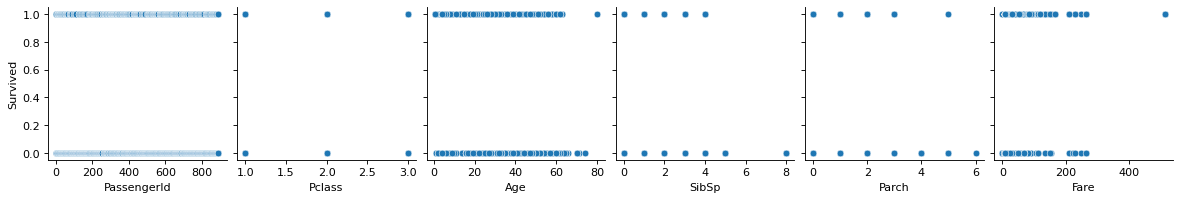

In [7]:
g= sns.pairplot(df,y_vars=['Survived'], x_vars=df.select_dtypes(include='number').columns.drop('Survived'), dropna=True)

Veiem que, aparentment, no hi ha cap correlació visible entre els atributs de ```X``` i els valors de ```y```, ja que els punts es distribueixen igual en l'eix d'abscisses

<Axes: >

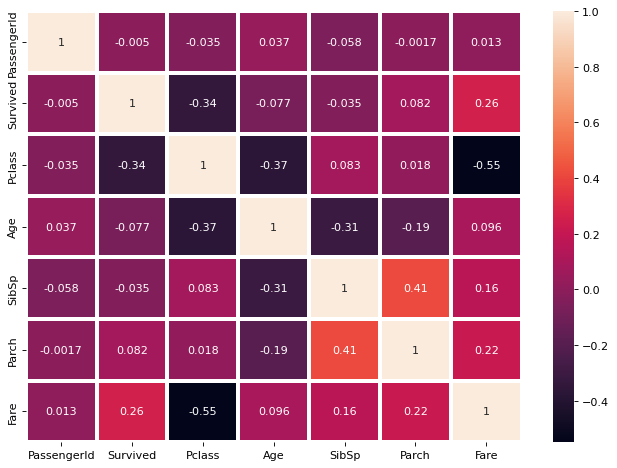

In [8]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True),annot=True,linewidths=2)

Veiem que, efectivament, la majoria d'atributs no té massa correlació amb el target ```y```, ja que els valors d'aquesta són propers a $0$. Els dos atributs amb més correlació són _Pclass_, amb una correlació negativa de $-0.34$, i _Fare_, amb una correlació positiva de $0.26$.

De fet, veiem que aquests dos atributs són els que tenen una major correlació entre ells (negativa de $-0.55$), cosa que és comprensible, ja que intuitivament podem imaginar que els passatges d'una classe més rica (un valor de _Pclass_ menor) tindrien una major despesa durant el viatge (_Fare_).

-  **Les etiquetes estan balancejades? (és a dir, hi ha una distribució similar entre categories?) Creus que la seva distribució pot afectar la classificació?**

    Per tal de veure com de ben distribuïts estan els valors dins de cada atribut, calcularem l'entropia de cada un d'ells. Per poder comparar-los i valorar-los correctament, normalitzarem el resultat entre $0$ i $1$ dividint-lo per l'entropia màxima de cada columna.

In [9]:
entropias = df.apply(lambda col: entropy(col.value_counts(normalize=True), base=2)/np.log2(col.nunique()))
entropias

PassengerId   1.0000
Survived      0.9607
Pclass        0.9081
Name          1.0000
Sex           0.9362
Age           0.9036
SibSp         0.4768
Parch         0.4019
Ticket        0.9810
Fare          0.8854
Cabin         0.9814
Embarked      0.6920
dtype: float64

Veiem que l'entropia a l'atribut target (*Survived*) és propera a $1$, pel que el dataset complet està força balancejat respecte a les classes del nostre problema.

Respecte els altres atributs, veiem que totes les etiquetes tenen una entropia propera a 1 excepte _SibSp_, _Parch_ i _Embarked_. Aquest fet no ens sorprenen, ja que abans hem vist que hi ha una correlació de les més altes entre atributs.

### 2. Preprocessament (*normalització, tractament d’outliers, selecció de variables...*) – **2 punts**

Un cop conegudes les dades disponibles, cal preparar-les per als algoritmes d’aprenentatge. Segons la tipologia de dades, es poden filtrar atributs, aplicar reductors de dimensionalitat, codificar categories textuals en valors numèrics, normalitzar, o bé detectar i eliminar *outliers*.  

Consulteu la [documentació de *scikit-learn* sobre preprocessament](https://scikit-learn.org/stable/modules/preprocessing.html) per explorar les diferents opcions que ofereix.  

**Preguntes:**  
-  **Les dades estan normalitzades? Caldria fer-ho?**

    No, observem que cada atribut té un rang de valors diferent. Seria recomanable normalitzar, ja que, si no ho fem, els atributs amb valors més grans tindran un pes superior durant l'entrenament del model, afectant el seu rendiment.

-  **En cas de normalitzar, quin tipus de normalització seria més adient per a les vostres dades?**
Pensem que la millor és la ```MinMaxScaler```, que normalitza els valors al rang $[0,1]$ de la següent manera: 

    $X_{normalitzat}=\frac{X-X_{min}}{X_{max}-X_{min}}$.    Això ens permetrà mapejar les dades al mateix rang.  


-  **Hi ha moltes dades sense informació (*NaNs*)? Tingueu en compte que alguns mètodes no les toleren durant l’aprenentatge.**  
   -  **Com afecta la classificació si les filtreu?**  
   -  **I si les reompliu? Com ho faríeu? [Pista](https://scikit-learn.org/stable/modules/impute.html)**

   Hem vist que tenim molts nans a la columna **Cabin** ($0.771$), i alguns a les columnes **Age** ($0.199$), **Embarked** ($0.002$).

   En primer lloc, degut al gran percentatge de NaNs, eliminarem **Cabin** directament.

   En segon lloc, pensem que, degut al baix percentatge, ens és convenient eliminar les files que tinguin un NaN a la columna **Embarked**. Després, hem pensat que la millor opció és emplenar els NaNs restants de l'atribut numèric **Age**, i ho farem amb la mitjana aritmètica de la columna.

   Aquest tractament que farem, considerem que és el que afectarà menys al rendiment del model.  


-  **Hi ha dades categòriques? Quina seria la codificació més adequada?**
Sí, hi ha dades categòriques: **Pclass**, **Name**, **Sex**, **Ticket**, **Cabin** i **Embarked**  

    Creiem que la codificació amb més sentit és l'```OrdinalEncoder```, ja que li atribuirà un valor numèric a cada categoria que tinguem per cada característica. On, per exemple, en el cas de **Sex**, li atribuirà els valors $0$ i $1$, ja que només tenen dos possibles valors (*male* i *female*).

-  **Es poden extreure atributs addicionals a partir de les variables categòriques (per exemple, aplicant alguna regla sobre el text)?**

    Sí, podem treure informació sobre l'**Estat Civil** de cada persona, en funció del títol al seu nom (Master, Mr., Miss., Mrs.,...).\
    Inicialment, no considerarem aquest nou atribut, però hem pensat que podem fer-ho si el model final no dona un rendiment adequat.


-  **Caldria aplicar PCA? Quins beneficis o inconvenients tindria?**
    
    Els beneficis d'aplicar PCA són que, al transformar els atributs antics en nous atributs ordenats per la quantitat d'informació que aporten, et pots quedar amb menys atributs que abans tot mantenint el màxim d'informació possible. Això pot ser útil per a visualitzar les dades en espais de dimensions habituals (2D o 3D), o bé quan es tenen moltíssims atributs i es volen reduir.

    El principal inconvenient és que el conjunt de tranformacions que aplica el PCA fa que tinguis unes dades amb uns nous valors que no et permeten identificar cap dels atributs originals (i per tant, arribar a conclusions fàcilment).

    Nosaltres l'utilitzarem més endavant per a visualitzar les classificacions que facin els models.


-  **Seria útil aplicar alguna tècnica de selecció de *features*? Ho trobeu necessari?**  

    Sí, mantindrem aquelles columnes que tinguin un valor absolut de correlació amb el target ```y``` major o igual al llindar $\boxed{0.05}$. També eliminarem directament aquelles columnes que pensem que no tenen sentit considerar ja que és impossible que tinguin relació amb el valor del target (**PassangerId**, **Name**).
    
    Sí, ho trobem necessari, ja que hi ha columnes que no aporten informació rellevant.

-  **Es podrien aplicar *PolynomialFeatures* per millorar la classificació? En quins models tindria sentit fer-ho?** 
L'aplicació de Polyoniaml té sentit amb models lineals (LogisticRegression, LinearSVC…) per capturar interaccions/no‑linearitats (grau 2 + regularització).

On no aporta gaire és a arbres/GBM/RandomForest, kNN o SVM RBF, que ja modelen no‑linearitats.

**Apliquem tot el que hem descrit a les preguntes anteriors:**

**TRACTAMENT DE NANS:**

In [10]:
# Eliminem directament Cabin
train = train.drop("Cabin", axis="columns")
test = test.drop("Cabin", axis="columns")

# Treiem les files amb NaNs a Embarked
train = train[~train["Embarked"].isna()]
test = test[~test["Embarked"].isna()]

train.loc[:,"Age"] = train["Age"].fillna(train["Age"].mean())
test.loc[:,"Age"] = test["Age"].fillna(test["Age"].mean())

train.isna().mean(axis = 0) + test.isna().mean(axis = 0)

PassengerId   0.0000
Pclass        0.0000
Name          0.0000
Sex           0.0000
Age           0.0000
SibSp         0.0000
Parch         0.0000
Ticket        0.0000
Fare          0.0000
Embarked      0.0000
Survived      0.0000
dtype: float64

**ENCONDING**

In [11]:
# Ajuntem les dades per tal de que la codificació sigui coherent en tots dos conjunts
n_train = train.shape[0]
df = pd.concat([train, test], axis=0)

oe = OrdinalEncoder()
df = oe.fit_transform(df)
df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
140,141,3,1,1,29.6740,0,2,1,15.2458,1,0
439,440,2,2,2,31.0000,0,0,2,10.5000,2,0
817,818,2,3,2,31.0000,1,1,3,37.0042,1,0
378,379,3,4,2,20.0000,0,0,4,4.0125,1,0
491,492,3,5,2,21.0000,0,0,5,7.2500,2,0
...,...,...,...,...,...,...,...,...,...,...,...
780,781,3,885,1,13.0000,0,0,677,7.2292,1,1
837,838,3,886,2,29.5152,0,0,678,8.0500,2,0
215,216,1,887,1,31.0000,1,0,412,113.2750,1,1
833,834,3,888,2,23.0000,0,0,679,7.8542,2,0


**NORMALITZACIÓ**

In [12]:
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(df)
df = pd.DataFrame(df_norm, columns=df.columns)
df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
0,0.1573,1.0000,0.0000,0.0000,0.3676,0.0000,0.3333,0.0000,0.0298,0.0000,0.0000
1,0.4933,0.5000,0.0011,1.0000,0.3843,0.0000,0.0000,0.0015,0.0205,0.5000,0.0000
2,0.9180,0.5000,0.0023,1.0000,0.3843,0.1250,0.1667,0.0029,0.0722,0.0000,0.0000
3,0.4247,1.0000,0.0034,1.0000,0.2460,0.0000,0.0000,0.0044,0.0078,0.0000,0.0000
4,0.5517,1.0000,0.0045,1.0000,0.2586,0.0000,0.0000,0.0059,0.0142,0.5000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
884,0.8764,1.0000,0.9955,0.0000,0.1581,0.0000,0.0000,0.9956,0.0141,0.0000,1.0000
885,0.9404,1.0000,0.9966,1.0000,0.3656,0.0000,0.0000,0.9971,0.0157,0.5000,0.0000
886,0.2416,0.0000,0.9977,0.0000,0.3843,0.1250,0.0000,0.6053,0.2211,0.0000,1.0000
887,0.9360,1.0000,0.9989,1.0000,0.2837,0.0000,0.0000,0.9985,0.0153,0.5000,0.0000


**SELECCIÓ DE FEATURES**

<Axes: >

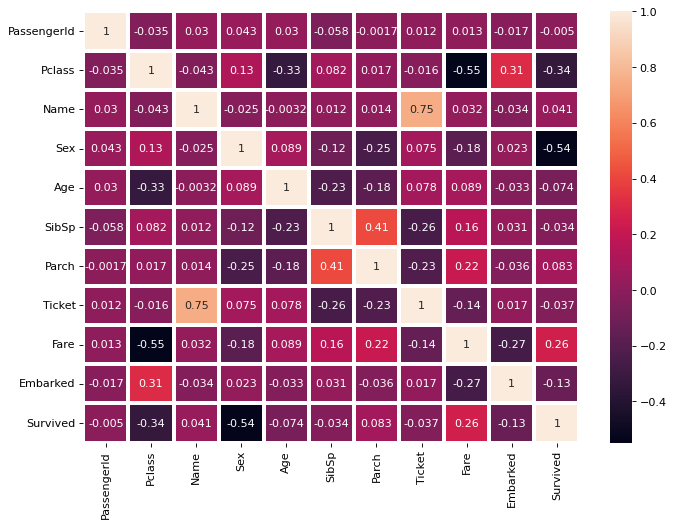

In [13]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True,linewidths=2)

In [14]:
llindar = 0.05

correlacions = df.corr()["Survived"]
seleccionades = correlacions[correlacions.abs() > llindar].index
df = df[seleccionades]
df

,Pclass,Sex,Age,Parch,Fare,Embarked,Survived
0,1.0000,0.0000,0.3676,0.3333,0.0298,0.0000,0.0000
1,0.5000,1.0000,0.3843,0.0000,0.0205,0.5000,0.0000
2,0.5000,1.0000,0.3843,0.1667,0.0722,0.0000,0.0000
3,1.0000,1.0000,0.2460,0.0000,0.0078,0.0000,0.0000
4,1.0000,1.0000,0.2586,0.0000,0.0142,0.5000,0.0000
...,...,...,...,...,...,...,...
884,1.0000,0.0000,0.1581,0.0000,0.0141,0.0000,1.0000
885,1.0000,1.0000,0.3656,0.0000,0.0157,0.5000,0.0000
886,0.0000,0.0000,0.3843,0.0000,0.2211,0.0000,1.0000
887,1.0000,1.0000,0.2837,0.0000,0.0153,0.5000,0.0000


In [15]:
# Tornem a separar les dades en el dos conjunts
train = df[:n_train]
test = df[n_train:]

y_train = train["Survived"]
X_train = train.drop("Survived", axis="columns")

y_test = test["Survived"]
X_test = test.drop("Survived", axis="columns")

Les noves correlacions després del pre-tractament de les dades són:

<Axes: >

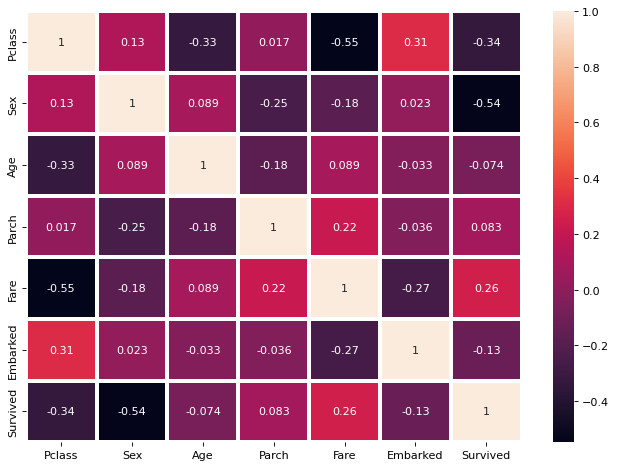

In [16]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True,linewidths=2)

### 3. Selecció de mètriques – **1.5 punts**

En aquest apartat ens centrarem en les mètriques de classificació ([documentació](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)).  

Per començar, entreneu una **regressió logística** (no cal separar *train-test*). A partir d’aquesta, genereu una sèrie de funcions per analitzar els resultats. Aquestes funcions serviran més endavant.  

També caldrà triar la mètrica que farem servir posteriorment per escollir el millor model.  

**Preguntes:**  
-  A teoria hem vist el comportament de l’`accuracy_score` en dades no balancejades. Quina de les següents mètriques creieu que és més adequada pel vostre problema? Justifiqueu-ho.  
   - `accuracy_score`  
   - `f1_score`  
   - `average_precision_score`  



En aquest apartat, decidirem les mètriques i mecanismes adequats per a analitzar el rendiment del nostre model final.

Definim algunes funcions que ens seran útils per a l'anàlisi dels resultats:

-  Abans d’entrenar models, genereu una suite de funcions per analitzar gràficament el rendiment.  
   -  Mostreu la *Precision-Recall Curve* i la *ROC Curve*.  
   -  Quina és més rellevant per al vostre dataset?  
   -  Expliqueu amb les vostres paraules la diferència entre ambdues. [Pista](https://stats.stackexchange.com/questions/338826/auprc-vs-auc-roc)


-  Què mostra el [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)?  
   -  Quina mètrica triareu per optimitzar la classificació en el vostre cas?  

> **Nota:** En aquest apartat **no es valoren els resultats obtinguts**. El que s’avalua és:  
> - L’elecció raonada de la mètrica de classificació.  
> - Saber quines gràfiques cal generar per analitzar els resultats.  
>   
> Recordeu: abans de solucionar un problema cal tenir molt clara la mètrica d’error que s’utilitzarà, i aquesta decisió s’ha de prendre **abans d’entrenar models**.  

### 4. Selecció de models amb validació creuada – **4 punts**

Fent servir la mètrica seleccionada a l’apartat anterior, cal escollir una sèrie de models i, mitjançant **validació creuada**, seleccionar el millor model amb els seus hiperparàmetres òptims, trobats a través d’una cerca (*hyperparameter search*).  

Aquesta tasca s’emmarca dins de l’aprenentatge computacional **supervisat**.  
A *scikit-learn* disposem de diverses tècniques ([documentació](https://scikit-learn.org/stable/supervised_learning.html)). A classe hem vist tècniques com:  
- Regressió logística  
- SVM amb diferents *kernels*  
- K-Nearest Neighbours (KNN)  
- Arbres de decisió  
- Random Forest  
- Gradient Boosting  

Per aquest apartat es demana seleccionar **un mínim de 4 models** (per exemple: regressió logística, random forest, KNN, SVM).  

**Preguntes:**  
-  Quins models heu considerat? Per què els heu seleccionat?  
 



-  Fent servir validació creuada, escolliu el millor model (amb hiperparàmetres per defecte).  
   -  Per què és important fer servir validació creuada?  
   -  Heu de fer servir algun [tipus específic de validació creuada](https://scikit-learn.org/stable/modules/cross_validation.html)?  


-  Seleccioneu un conjunt d’**hiperparàmetres** a provar per a cada model i realitzeu la cerca corresponent.  
   -  Hi ha algun model que es pugui descartar de primeres? Per què?  


-  Mostreu els resultats en una taula amb: model, experiments realitzats, resultats (train i test) i, opcionalment, temps d’entrenament.  


-  Quin tipus de **K-fold** heu escollit per a la selecció de models i per a la selecció amb hiperparàmetres?  
   -  Com afecta el nombre de folds al resultat final?  


-  Quines formes de buscar el millor paràmetre heu trobat?  
   -  Són costoses computacionalment?  
   -  [Documentació *Grid Search*](https://scikit-learn.org/stable/modules/grid_search.html)  
   -  Quina heu seleccionat?  


-  Si disposem de recursos limitats (per exemple, un PC durant 1 hora), quin mètode creieu que donarà millor resultat final?  


-  Existeixen mètodes de cerca més eficients? ([scikit-optimize](https://scikit-optimize.github.io/stable/))  


-  Opcional: Configureu diferents mètodes de cerca per executar-se durant el mateix temps (0,5–1 h) amb el model i el mètode de cross-validation escollit.  
   -  Analitzeu quin ha arribat a una millor solució.  
   -  (Ajuda: estimeu el temps d’entrenament d’un model per trobar el número d’iteracions possibles.) 

### 5. Anàlisi final – **1.5 punts**

Un cop seleccionat el millor model amb els hiperparàmetres òptims, cal elaborar un **report final** amb els resultats obtinguts.  

**Preguntes:**  
-  Mostreu les corbes ROC/PR (la que hàgiu escollit a l’apartat 3) i interpreteu els resultats.  


-  Analitzeu en detall les diferents mètriques que considereu adients.  
    - Comentar breument com podríeu aplicar aquest model en un futur (cas d’ús).  


-  Quines possibles millores es podrien fer al vostre model?  